In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [7]:
# Leer archivo txt de dos columnas: tiempo y porcentaje de conversión
archivo1 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C1.txt"
archivo2 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C2.txt"
archivo3 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina.txt"

data_txt1 = pd.read_csv(archivo1, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt2 = pd.read_csv(archivo2, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt3 = pd.read_csv(archivo3, sep="\s+", header=None, names=["Tiempo", "Porcentaje", "Error"])

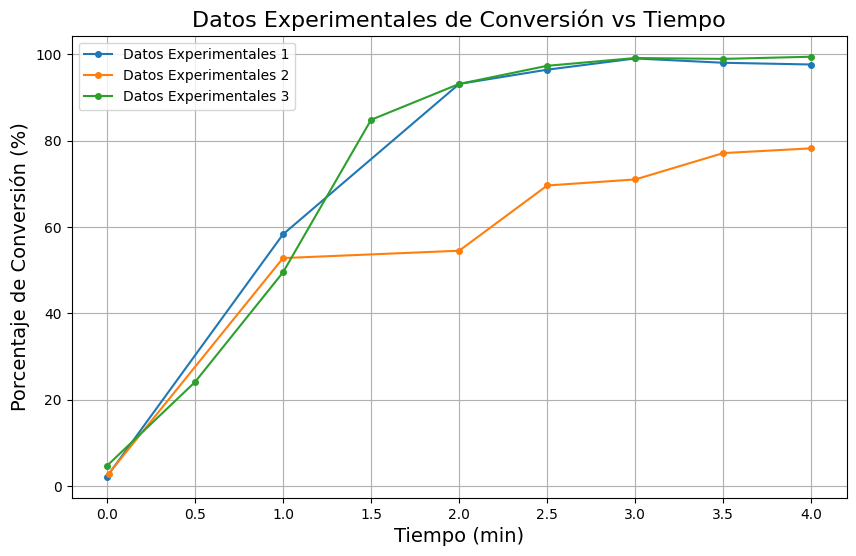

In [8]:

Experiments = [data_txt1, data_txt2, data_txt3]

plt.figure(figsize=(10, 6))
for i, exp in enumerate(Experiments, start=1):
    plt.plot(exp["Tiempo"], exp["Porcentaje"], '-o', label=f'Datos Experimentales {i}', markersize=4)
plt.xlabel('Tiempo (min)', fontsize=14)
plt.ylabel('Porcentaje de Conversión (%)', fontsize=14)
plt.title('Datos Experimentales de Conversión vs Tiempo', fontsize=16)
plt.legend()
plt.grid()
plt.show()

Simulación terminada en 8.62 s (una réplica)
Params
k_ads_coeff: 0.001
k_des: 0.004
k_diff: 1.3
k_att: 0.2
V: 1.0
N_bulk0: 1500
seed_coords: [(np.int64(25), np.int64(23)), (np.int64(36), np.int64(7)), (np.int64(36), np.int64(16)), (np.int64(5), np.int64(10)), (np.int64(23), np.int64(34)), (np.int64(15), np.int64(5)), (np.int64(18), np.int64(1)), (np.int64(32), np.int64(30)), (np.int64(2), np.int64(32)), (np.int64(34), np.int64(21)), (np.int64(20), np.int64(31)), (np.int64(19), np.int64(11)), (np.int64(30), np.int64(11)), (np.int64(7), np.int64(3)), (np.int64(21), np.int64(2)), (np.int64(15), np.int64(16)), (np.int64(18), np.int64(21)), (np.int64(0), np.int64(37)), (np.int64(37), np.int64(1)), (np.int64(8), np.int64(4)), (np.int64(32), np.int64(7)), (np.int64(1), np.int64(10)), (np.int64(21), np.int64(4)), (np.int64(8), np.int64(34)), (np.int64(7), np.int64(14)), (np.int64(19), np.int64(6)), (np.int64(14), np.int64(19)), (np.int64(22), np.int64(32)), (np.int64(14), np.int64(37)), (np.in

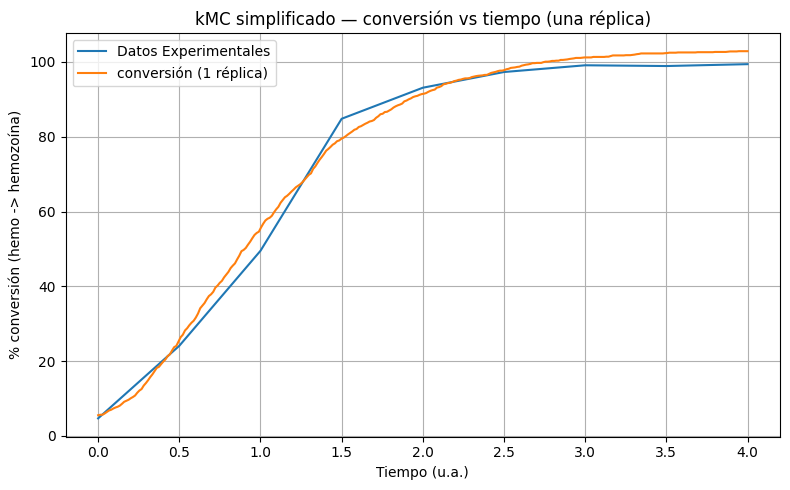

Resultados guardados en conversion_time_single.csv


In [ ]:
"""
kMC simplificado (Gillespie / BKL) para simular % conversión:
hemo (bulk) --> adatom (adsorbido) --> incorporado (cristal)

Diseño:
- Lattice 2D (L x L) que representa la superficie.
- Estados de celda: 0 = vacío, 1 = adatom, 2 = incorporado.
- Eventos: Adsorción, Desorción, Difusión, Incorporación.
- Sistema cerrado: N_bulk se decrementa al ocurrir adsorción.
- Se inicializa con una semilla para permitir crecimiento.
- Output: curva % conversión (promedio +/- std si se hacen réplicas).

Para ejecutar: guardar como `kmc_hemo.py` y ejecutar `python kmc_hemo.py`
Recomendado usar Python 3.8+ y tener instalados numpy, pandas, matplotlib.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


# ------------------ Generar n semillas aleatorias ------------------
def random_seeds(L, n, rng):
    seeds = set()
    while len(seeds) < n:
        x = rng.integers(0, L)
        y = rng.integers(0, L)
        seeds.add((x, y))   # set evita duplicados
    return list(seeds)





# ------------------ Funciones auxiliares ------------------
def neighbors(ix, iy, L):
    # 4 vecinos con condiciones periódicas
    return [((ix-1) % L, iy), ((ix+1) % L, iy), (ix, (iy-1) % L), (ix, (iy+1) % L)]

# ------------------ kMC por réplica ------------------
def run_single_replica(L, N_bulk0, seed_coords, T_max, max_events,
                       k_ads_coeff, k_des, k_diff, k_att, V, rng):
    lattice = np.zeros((L, L), dtype=np.int8)
    # colocar semillas incorporadas
    for (x,y) in seed_coords:
        lattice[x % L, y % L] = 2

    N_bulk = N_bulk0
    N_inc = len(seed_coords)
    adatom_positions = set()
    incorporated_positions = set((x % L, y % L) for (x,y) in seed_coords)

    t = 0.0
    times = [t]
    convs = [100.0 * N_inc / N_bulk0]

    event_count = 0
    while t < T_max and N_bulk > 0 and event_count < max_events:
        event_count += 1
        C = N_bulk / V
        N_empty_sites = np.sum(lattice == 0)
        ad_list = list(adatom_positions)
        N_adatoms = len(ad_list)

        # tasas agregadas
        rate_ads = k_ads_coeff * C * N_empty_sites
        rate_des = k_des * N_adatoms
        rate_diff = k_diff * N_adatoms

        # detectar adatoms en contacto con cristal (una pasada sobre ad_list)
        adatoms_touching_crystal = []
        if N_adatoms > 0:
            for (x,y) in ad_list:
                nx1, ny1 = (x-1) % L, y
                nx2, ny2 = (x+1) % L, y
                nx3, ny3 = x, (y-1) % L
                nx4, ny4 = x, (y+1) % L
                if (lattice[nx1, ny1] == 2) or (lattice[nx2, ny2] == 2) or \
                   (lattice[nx3, ny3] == 2) or (lattice[nx4, ny4] == 2):
                    adatoms_touching_crystal.append((x,y))

        N_touch_att = len(adatoms_touching_crystal)
        rate_att = k_att * N_touch_att

        R_total = rate_ads + rate_des + rate_diff + rate_att
        if R_total <= 0:
            break

        # tiempo al próximo evento (Gillespie)
        u = rng.random()
        dt = -np.log(u) / R_total / 10
        t += dt

        # seleccionar evento por muestreo ponderado
        r = rng.random() * R_total
        cum = 0.0

        # Adsorción
        cum += rate_ads
        if r < cum:
            if N_bulk <= 0 or N_empty_sites == 0:
                continue
            empties = np.argwhere(lattice == 0)
            choice = tuple(empties[rng.integers(0, len(empties))])
            lattice[choice] = 1
            adatom_positions.add((choice[0], choice[1]))
            N_bulk -= 1
            times.append(t); convs.append(100.0 * N_inc / N_bulk0)
            continue

        # Desorción
        cum += rate_des
        if r < cum:
            if N_adatoms == 0:
                continue
            idx = rng.integers(0, N_adatoms)
            pos = ad_list[idx]
            lattice[pos] = 0
            adatom_positions.remove(pos)
            N_bulk += 1
            times.append(t); convs.append(100.0 * N_inc / N_bulk0)
            continue

        # Difusión
        cum += rate_diff
        if r < cum:
            if N_adatoms == 0:
                continue
            idx = rng.integers(0, N_adatoms)
            pos = ad_list[idx]
            x,y = pos
            nbrs = neighbors(x,y,L)
            rng.shuffle(nbrs)
            for nx, ny in nbrs:
                if lattice[nx, ny] == 0:
                    lattice[x, y] = 0
                    lattice[nx, ny] = 1
                    adatom_positions.remove((x,y))
                    adatom_positions.add((nx,ny))
                    break
            times.append(t); convs.append(100.0 * N_inc / N_bulk0)
            continue

        # Incorporación
        cum += rate_att
        if r < cum:
            if N_touch_att == 0:
                continue
            pos = adatoms_touching_crystal[rng.integers(0, N_touch_att)]
            x,y = pos
            lattice[x, y] = 2
            adatom_positions.remove((x,y))
            incorporated_positions.add((x,y))
            N_inc += 1
            times.append(t); convs.append(100.0 * N_inc / N_bulk0)
            continue

    # devolver DataFrame remuestreado en una grilla temporal para promediar
    df = pd.DataFrame({'time': times, 'conversion_pct': convs})
    t_grid = np.linspace(0, T_max, 300)
    conv_interp = np.interp(t_grid, df['time'], df['conversion_pct'])
    df_grid = pd.DataFrame({'time': t_grid, 'conversion_pct': conv_interp})
    return df_grid

# ------------------ Ejecutar réplicas y agregar resultados ------------------
# ------------------ Ejecutar una sola réplica ------------------
start = time.time()
df_single = run_single_replica(L, N_bulk0, seed_coords, T_max, max_events,
                               k_ads_coeff, k_des, k_diff, k_att, V,
                               rng)
end = time.time()

# ------------------ Parámetros ------------------
L = 40               # tamaño del lattice (L x L)
N_bulk0 = 1500
n_seeds = 0.055 * N_bulk0      # unidades iniciales de heme en bulk
seed_coords = random_seeds(L, n_seeds, rng)  # semilla inicial (lista de tuplas)
T_max = 4       # tiempo máximo de simulación (u.a.)
n_replicas = 4       # réplicas para promediar
max_events = 50000   # tope de eventos por réplica (protección)

# Tasas (valores de ejemplo; calibrar con datos)
k_ads_coeff = 0.001   # coef adsorción por sitio * C
k_des = 0.004         # desorción por adatom
k_diff = 1.3         # difusión por adatom
k_att = 0.2          # incorporación por adatom en contacto con cristal
V = 1.0              # volumen (para convertir N_bulk -> C)

rng = np.random.default_rng(42)


# ------------------ Mostrar resultados ------------------
print(f"Simulación terminada en {end-start:.2f} s (una réplica)")

print('Params')
print(f"k_ads_coeff: {k_ads_coeff}")
print(f"k_des: {k_des}")
print(f"k_diff: {k_diff}")
print(f"k_att: {k_att}")
print(f"V: {V}")
print(f"N_bulk0: {N_bulk0}")
print(f"seed_coords: {seed_coords}")

# Gráfica (matplotlib; una figura)
plt.figure(figsize=(8,5))
plt.plot(Experiments[2]['Tiempo'], Experiments[2]['Porcentaje'], label='Datos Experimentales')
plt.plot(df_single['time'], df_single['conversion_pct'], label='conversión (1 réplica)')
plt.xlabel('Tiempo (u.a.)')
plt.ylabel('% conversión (hemo -> hemozoína)')
plt.title('kMC simplificado — conversión vs tiempo (una réplica)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# (Opcional) exportar resultados
df_single.to_csv('conversion_time_single.csv', index=False)
print("Resultados guardados en conversion_time_single.csv")




In [ ]:
N_seed = int(0.10 * N_bulk0)
